In [1]:
# import standard python modules
# you may need to install lenstronomy and Anaconda environment
# pip install lenstronomy==1.10.2
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from scipy.optimize import minimize
from scipy.optimize import dual_annealing


In [2]:
#---------------step-1 generate the mock lens data that we are going to model-------------------------------------
# choose a lens model parameterization
lens_model_list = ['SIE']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)

# choose the source parameters of mock lens
x_source, y_source = 0.0, 0.0 #source position
flux_source = 1.0 #source flux

#set the mock lens parameters
#Note, we are working on ellipticity instead of the axis-ratio and position angle.
#see eq.7 and sec-4.2.1 in https://arxiv.org/abs/1504.07629 why we use the ellipticity
kwargs_sie = {'theta_E':1.2, 'e1': -0.05, 'e2':0.15, 'center_x':0.0, 'center_y':0.0}
kwargs_lens_list = [kwargs_sie]

# compute image position of full model (with some numerical options attached)
x_image_data, y_image_data = lensEquationSolver.image_position_from_source(
    kwargs_lens=kwargs_lens_list, 
    sourcePos_x=x_source, 
    sourcePos_y=y_source, 
    min_distance=0.1, 
    search_window=5, 
    precision_limit=10**(-10), 
    num_iter_max=30,
    solver = 'lenstronomy',
    non_linear=False,
    arrival_time_sort=False,
)

images_mag = lensModel.magnification(x_image_data, y_image_data, kwargs_lens_list) #shape: [nimages,]
images_mag = np.abs(images_mag) #magnification can be negtive due to the image parity
image_flux_data = images_mag * flux_source

#------------add noise to postion and flux
pos_err_data = 0.005 # 5 mas (milli-arcsec) astrometry uncertainties
flux_err_data = np.ones_like(images_mag, dtype='float') * 0.05 #the (assumed) uncertainties of flux.

x_image_data += np.random.normal(loc=0.0, scale=pos_err_data, size=len(x_image_data)) #add gaussian noise to represent the astrometry uncertainties
y_image_data += np.random.normal(loc=0.0, scale=pos_err_data, size=len(x_image_data))
for ii in range(len(flux_err_data)):
    image_flux_data[ii] += np.random.normal(loc=0.0, scale=flux_err_data[ii]) #add the gaussian flux noise

print(x_image_data, y_image_data)



[-0.6574508   1.01242363 -1.0199397   0.66522247] [-0.91482752 -0.73498893  0.73614824  0.91265274]


In [3]:
def sort_lensed_images(ximages_data, yimages_data, ximages_model, yimages_model):
    paired_indices = []
    for x0,y0 in zip(ximages_data, yimages_data):
        r0 = np.sqrt((ximages_model-x0)**2 + (yimages_model-y0)**2)
        paired_indices.append(np.argmin(r0))

    if len(ximages_data) >= len(ximages_model):
        paired_indices = paired_indices[0:len(ximages_model)]
        return ximages_model[paired_indices], yimages_model[paired_indices]
    else:
        unpaired_indices = [item for item in range(len(ximages_model)) if item not in paired_indices]
        return ximages_model[paired_indices+unpaired_indices], yimages_model[paired_indices+unpaired_indices]


class lens_fitter(object):
    def __init__(self, images_x_data, images_y_data, flux_data, pos_err_data=0.001, flux_err_data=None):
        self.images_x_data = images_x_data
        self.images_y_data = images_y_data
        self.flux_data = flux_data #an arrary
        self.pos_err_data = pos_err_data #the measurement uncertainty of position on lens plane, a number.
        self.flux_err_data = flux_err_data #an array

        self.lensModel = LensModel(['SIE'])
        self.lens_params_name = ["thetaE","e1","e2"] #we have assume the lens mass center is (0, 0)
        self.lensEquationSolver = LensEquationSolver(self.lensModel) 

        if len(self.flux_data) != len(self.images_x_data):
            raise Exception('The number of flux data must equal to the number of lensed images')
        if len(self.flux_err_data) != len(self.images_x_data):
            raise Exception('The number of flux error data must equal to the number of lensed images')


    def solve_model_solution(self, cube):
        self.thetaE, self.e1, self.e2, self.xs, self.ys, self.src_flux = cube[0], cube[1], cube[2], cube[3], cube[4], cube[5]
        kwargs_sie = {'theta_E': self.thetaE, 'e1': self.e1, 'e2': self.e2, 'center_x': 0.0, 'center_y': 0.0}
        kwargs_lens_list = [kwargs_sie]        

        self.x_image_model, self.y_image_model = self.lensEquationSolver.image_position_from_source(
            kwargs_lens=kwargs_lens_list, 
            sourcePos_x=self.xs, 
            sourcePos_y=self.ys, 
            min_distance=0.1, 
            search_window=5, 
            precision_limit=10**(-10), 
            num_iter_max=30,
            solver='lenstronomy',
            non_linear=False,
            arrival_time_sort=False,
        )

        if len(self.x_image_model) > 0: #handle the extreme cases
            self.x_image_model, self.y_image_model = sort_lensed_images(self.images_x_data, self.images_y_data, self.x_image_model, self.y_image_model)
            self.model_mag = self.lensModel.magnification(self.x_image_model, self.y_image_model, kwargs_lens_list) #shape: [nimages,]
            self.model_mag = np.abs(self.model_mag)


    def merit(self, cube):
        self.solve_model_solution(cube)
        if len(self.images_x_data) != len(self.x_image_model): 
            return 1e90 #if the number of lensed images predicted by model is not equal to the data, that solution should be thrown away directly
        else:
            return self.merit_position() + self.merit_flux()


    def merit_position(self):
        self.chi2_position = (self.x_image_model - self.images_x_data)**2 / self.pos_err_data**2 + (self.y_image_model - self.images_y_data)**2 / self.pos_err_data**2
        self.chi2_position = np.sum(self.chi2_position)
        return self.chi2_position


    def merit_flux(self):
        self.chi2_flux = np.sum((self.flux_data - self.model_mag*self.src_flux)**2 / self.flux_err_data**2)
        return self.chi2_flux


    def fit(self):
        self.result_0 = dual_annealing(
            self.merit, 
            bounds=[(0, 3), (-0.3, 0.3) ,(-0.3, 0.3), (-1.0, 1.0), (-1.0, 1.0), (0, 10)], 
            maxiter=3000,
        ) #find a good start point near the global minimum
        start_point = self.result_0['x']
        
        self.result = minimize(
            self.merit, 
            start_point, 
            method='Nelder-Mead', 
            tol=1e-10, 
            bounds=[(0, 3), (-0.3, 0.3) ,(-0.3, 0.3), (-1.0, 1.0), (-1.0, 1.0), (0, 10)],
            options={'maxiter': 3000,},
        ) #do the optimization again




In [4]:
#--------------do the lens modelling
import time
t0 = time.time()
this_lens_fit = lens_fitter(x_image_data, y_image_data, image_flux_data, pos_err_data, flux_err_data)
this_lens_fit.fit() #do lens fitting
print(this_lens_fit.result) #show fitting results
t1 = time.time()
print('=====total time elapsed======', t1-t0)



 final_simplex: (array([[ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01],
       [ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01],
       [ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01],
       [ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01],
       [ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01],
       [ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01],
       [ 1.20026265e+00, -4.93740553e-02,  1.50102281e-01,
        -6.53963159e-04,  2.99198769e-04,  9.97042114e-01]]), array([1.73523062, 1.73523062, 1.73523062, 1.73523062, 1.73523062,
       1.73523062, 1.73523062]))
           fun: 1.735230619575842
       message

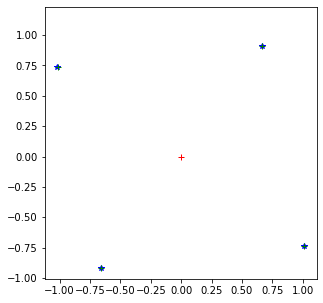

In [5]:
#-----------show modeling results
this_lens_fit.merit(this_lens_fit.result['x'])
lensModel = LensModel(['SIE'])
thetaE, e1, e2, xs, ys, fsrc = this_lens_fit.result['x']
kwargs_sie = {'theta_E': thetaE, 'center_x': 0.0, 'center_y': 0.0, 'e1': e1, 'e2': e2}
kwargs_lens_list = [kwargs_sie]
lensEquationSolver = LensEquationSolver(lensModel)
x_image_model, y_image_model = lensEquationSolver.image_position_from_source(
    kwargs_lens=kwargs_lens_list, 
    sourcePos_x=xs, 
    sourcePos_y=ys, 
    min_distance=0.1, 
    search_window=5, 
    precision_limit=10**(-10), 
    num_iter_max=30,
    solver = 'lenstronomy',
    non_linear=False,
    arrival_time_sort=False,
)
plt.figure(figsize=(5,5))
plt.plot(x_image_data, y_image_data, 'b*') #lensed images positions of mock data
plt.plot([0], [0], 'r+') #lens mass center
plt.plot(x_image_model, y_image_model , 'g+') #our model reconstruction
plt.axis('square')
# plt.savefig('lensed_qso.png')
plt.show()
plt.close()

# print(this_lens_fit.merit([1.2, -0.05, 0.15, 0.0, 0.0, 1.0]))


In [6]:
npar_sie = 3 #number of free parameters of sie, note, we fix the lens center to (0,0)
npar_src = 3 #x_src, y_src, flux_src
ndof = len(x_image_data) + len(y_image_data) + len(image_flux_data) - npar_src - npar_sie
print('degree of freedom:', ndof)
print('chi-square:', this_lens_fit.result['fun'])
# print('reduced chi-square:', this_lens_fit.result['fun']/ndof)



degree of freedom: 6
chi-square: 1.735230619575842
